In [622]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation

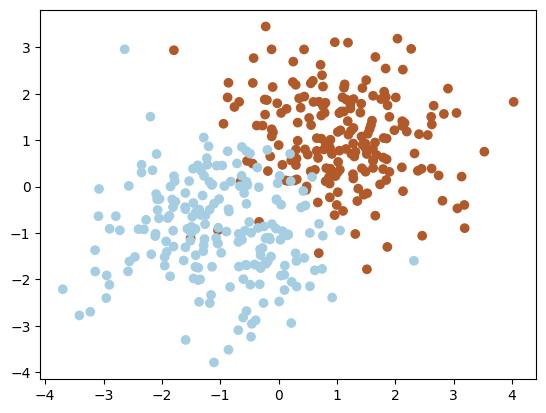

In [623]:
# 数据准备
NUM = 200
np.random.seed(1)
x1 = np.random.randn(NUM,2)+[1,1]
x2 = np.random.randn(NUM,2)-[1,1]
X = np.concatenate((x1,x2),axis=0)
y = np.concatenate((np.ones(NUM),-np.ones(NUM)),axis=0)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.Paired)
ax = plt.gca()

C = 1 # 惩罚系数
tol = 0.001 # 容忍度
max_iter = 1000 # 最大迭代次数
m,n = X.shape # m个样本，n个特征
alpha = np.zeros(m) # 初始化拉格朗日乘子
b = 0 # 初始化截距
iters = 0 # 初始化迭代数


In [624]:
def kernel(x,y,type='linear'):
    if type == 'linear':
        result = np.dot(x,y)
    return result

def f_i(num,alpha,b):
    result = np.dot(alpha*y,kernel(X,X[num]))+b
    return result

def Error(num,alpha,b):
    result = f_i(num,alpha,b)-y[num]
    return result

def KKT_error_distance(num,alpha,b):
    if alpha[num] == 0:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta < 0:
            return abs(delta)
        else:
            return 0
    elif alpha[num] > 0 and alpha[num] < C:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta == 0:
            return 0
        else:
            return abs(delta)
    elif alpha[num] == C:
        delta = y[num]*f_i(num,alpha,b) - 1
        if delta > 0:
            return abs(delta)
        else:
            return 0
        
def KKT_error(X,alpha,b,type='max'):
    result = []
    for i in range(np.shape(X)[0]):
        result.append([KKT_error_distance(i,alpha,b),i])
    result = pd.DataFrame(result)
    if type == 'max':
        result = result.sort_values(by=[0,1])
        result = [result.iloc[-1].name,result.iloc[-1].values[0]]
        return result
    if type == 'list':
        return result


def eta(i,j):
    result = kernel(X[i],X[i]) + kernel(X[j],X[j]) - 2*kernel(X[i],X[j])
    return result

def cut_off(alpha_old,i,j,Ei_old,Ej_old):
    if y[i] != y[j]:
        L = max(0,alpha_old[j]-alpha_old[i])
        H = min(C,C+alpha_old[j]-alpha_old[i])
    else:
        L = max(0,alpha_old[j]+alpha_old[i]-C)
        H = min(C,alpha_old[j]+alpha_old[i])
    alpha_j = alpha_old[j] + y[j]*(Ei_old-Ej_old)/eta(i,j)
    alpha_j = min(alpha_j,H)
    alpha_j = max(alpha_j,L)
    return alpha_j



In [625]:
def step_svm(X,alpha,b,tol=0.001,C=1):
    while True:
        num_alpha_change = 0
        for i in range(m):
            E1 = Error(i,alpha,b)
            if (y[i]*E1 < -tol and alpha[i] < C) or (y[i]*E1 > tol and alpha[i] > 0):
                j = np.random.choice([k for k in range(X.shape[0]) if k != i])
                E2 = Error(j,alpha,b)

                alpha_old_i = alpha[i]
                alpha_old_j = alpha[j]

                if eta(i,j) <= 0:
                    continue

                alpha[j] = cut_off(alpha,i,j,E1,E2)
                
                if abs(alpha[j] - alpha_old_j) < 0.0001:
                    continue
                
                alpha[i] = alpha_old_i + y[i]*y[j]*(alpha_old_j - alpha[j])

                b1 = b - E1 - y[i]*(alpha[i]-alpha_old_i)*kernel(X[i],X[i]) - y[j]*(alpha[j]-alpha_old_j)*kernel(X[i],X[j])
                b2 = b - E2 - y[i]*(alpha[i]-alpha_old_i)*kernel(X[i],X[j]) - y[j]*(alpha[j]-alpha_old_j)*kernel(X[j],X[j])

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1+b2)/2
                
                num_alpha_change += 1
            
        KKT = KKT_error(X,alpha,b,type='list')
        if KKT[0].max() < tol:
            w = np.dot(alpha*y,X)
            print('KKT条件满足')
            return w,b,True

        if num_alpha_change == 0:
            continue
        else:
            break
    w = np.dot(alpha*y,X)

    return w,b,False

In [626]:
def svm(alpha,b,X,tol=0.001,C=1,max_iter=1000):
    iters = 0
    result = []
    while iters < max_iter:
        for i in range(m):
            E1 = Error(i,alpha,b)
            if (y[i]*E1 < -tol and alpha[i] < C) or (y[i]*E1 > tol and alpha[i] > 0):
                j = np.random.choice([k for k in range(X.shape[0]) if k != i])
                E2 = Error(j,alpha,b)

                alpha_old_i = alpha[i]
                alpha_old_j = alpha[j]

                if eta(i,j) <= 0:
                    continue

                alpha[j] = cut_off(alpha,i,j,E1,E2)
                
                if abs(alpha[j] - alpha_old_j) < 0.0001:
                    continue
                
                alpha[i] = alpha_old_i + y[i]*y[j]*(alpha_old_j - alpha[j])

                b1 = b - E1 - y[i]*(alpha[i]-alpha_old_i)*kernel(X[i],X[i]) - y[j]*(alpha[j]-alpha_old_j)*kernel(X[i],X[j])
                b2 = b - E2 - y[i]*(alpha[i]-alpha_old_i)*kernel(X[i],X[j]) - y[j]*(alpha[j]-alpha_old_j)*kernel(X[j],X[j])

                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1+b2)/2
                w = np.dot(alpha*y,X)
                
                result.append([w,b,alpha])
        iters += 1
    return result

In [627]:
solution = svm(alpha,b,X,tol=0.001,C=1,max_iter=1000)

In [628]:
KKT = KKT_error(X,solution[0][2],solution[0][1],type='list')

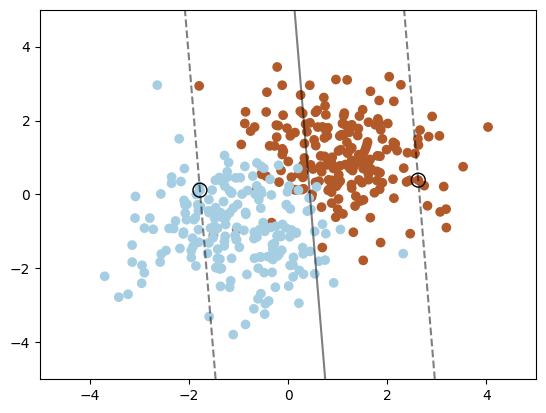

In [630]:
from IPython.display import HTML

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    w = solution[i][0]
    b = solution[i][1]
    xx = np.linspace(-5, 5, 30)
    yy = np.linspace(-5, 5, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = np.dot(xy, w.T) + b
    Z = Z.reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    ax.scatter(X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.001)[0], 0],
                X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.001)[0], 1],
                marker='o', s=100, edgecolors='k', facecolors='none')
    ax.scatter(X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.001)[0], 0],
                X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.001)[0], 1],
                marker='o', s=100, edgecolors='k', facecolors='none')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

anim = FuncAnimation(fig, animate, frames=len(solution), interval=15)

# 使用HTML模块将动画转换为可在Jupyter中显示的HTML
anim.save('svm.gif', fps=30)


In [ ]:
anim.save('svm.gif', fps=30)

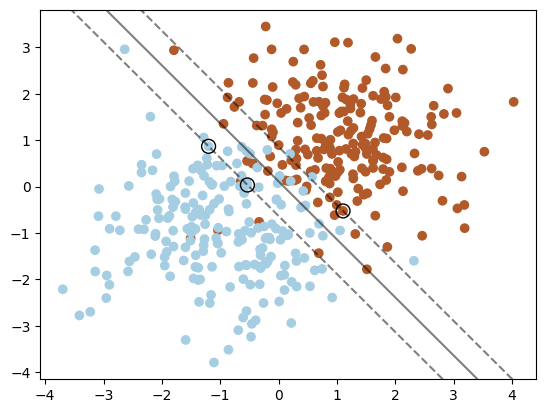

In [558]:
# 绘制数据集和决策边界
w = solution[0][0]
b = solution[0][1]
alpha = solution[0][2]
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 生成网格点并预测分类
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = np.dot(xy, w.T) + b

# 绘制决策边界和支持向量
Z = Z.reshape(XX.shape)
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.001)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b - 1) < 0.001)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')
plt.scatter(X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.001)[0], 0],
            X[np.where(np.abs(np.dot(X, w.T) + b + 1) < 0.001)[0], 1],
            marker='o', s=100, edgecolors='k', facecolors='none')

In [ ]:
# 该代码用于计算最大KKT损失以优化alpha_j的计算速度
# def inner_any(alpha_old,i,j):
#     index = np.asarray([index for index, value in enumerate(alpha)])
#     choice_index = index[(alpha < 1) & (alpha > 0)]
#     for k in choice_index:
#         if k == i:
#             continue
#         else:
#             j = k
#             result = cut_off(alpha_old,i,j,Error(i,alpha,b),Error(j,alpha,b))
#             if abs(result - alpha_old[j]) < 0.0001:
#                 continue
#             else:
#                 return (result,j)
#     for k in index:
#         j = np.random.choice(index)
#         if j == i:
#             continue
#         else:
#             result = cut_off(alpha_old,i,j,Error(i,alpha,b),Error(j,alpha,b))
#             if abs(result - alpha_old[j]) < 0.0001:
#                 continue
#             else:
#                 return (result,j)
#     raise Exception('No suitable j is found')

# def E_choice(num,alpha,b,type='choice'):
#     result = []
#     for i in range(np.shape(X)[0]):
#         result.append([Error(i,alpha,b),i])
#     result = pd.DataFrame(result).sort_values(by=[0,1])
#     E1 = Error(num,alpha,b)
#     if type == 'choice':
#         if E1 > 0:
#             result = [result.iloc[0].name,result.iloc[0].values[0]]
#         elif E1 < 0:
#             result = [result.iloc[-1].name,result.iloc[-1].values[0]]
#         else:
#             result = abs(result).sort_values(by=[0,1])
#             result = [result.iloc[-1].name,result.iloc[-1].values[0]]
#         return result
#     if type == 'list':
#         return result
    

# def choice_i_j(X,alpha,b):
#     i = KKT_error(X,alpha,b)[0]
#     j = E_choice(i,alpha,b)[0]
#     return i,j